In [76]:
import torch as th
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score

#сделаем инициализацию random seed, 
#чтобы наши эксперименты были воспроизводимы

random.seed(0)
np.random.seed(0)
th.manual_seed(0)
th.cuda.manual_seed(0)
th.backends.cudnn.deterministic=True

In [77]:
#скачивание датасета для классификации изображений
import torchvision.datasets

MNIST_train = torchvision.datasets.MNIST('./', download = True, train = True)
MNIST_test = torchvision.datasets.MNIST('./', download = True, train = False)

In [78]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels


/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [79]:
y_train

tensor([5, 0, 4,  ..., 5, 6, 8])

In [80]:
pd_y_train = pd.DataFrame(MNIST_train.train_labels, columns = ["o"]) 

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [81]:
pd_y_train.groupby(["o"]).size()/len(pd_y_train)*100
#Классы сбалансирвоанны

o
0     9.871667
1    11.236667
2     9.930000
3    10.218333
4     9.736667
5     9.035000
6     9.863333
7    10.441667
8     9.751667
9     9.915000
dtype: float64

In [82]:
#посмотрим какой у данных тип
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [83]:
#данные имеют тип беззнаковый 8, а таргеты - целые 64 бита
#преобразуем сразу данные в веществиенный тип
X_train = X_train.float()
X_test = X_test.float()

In [84]:
#посмотрим на расзмерность датасетов
X_train.shape, X_test.shape
#это очень маленькие картинки, именно поэтому мы можем использовать
#полносвязную нейронную сеть для такой задачи, а не сверточные сети

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [85]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

In [86]:
#у нас трезмерный тензор, мы хотим двумерный тензор, 
#чтобы первая рамерность сохранилась, то есть 60000 картинок
#вместо 28 и 28 будет 764 пикселя

X_train = X_train.reshape([-1, 28*28])

X_test = X_test.reshape([-1, 28*28])

y_new_train = th.zeros(len(y_train), 10)
for i in range(0, len(y_train)):
  y_new_train[i, y_train[i]] = 1
y_new_test = th.zeros(len(y_test), 10)
for i in range(0, len(y_test)):
  y_new_test[i, y_test[i]] = 1

In [87]:
#Создание сети
# на выходе у нас числа от 0 до 9
class MNISTnet(th.nn.Module):
  def __init__(self):
    super (MNISTnet, self).__init__()
    self.fc1 = th.nn.Linear(28**2, 256)
    self.act1 = th.nn.ReLU()
    self.fc2 = th.nn.Linear(256, 128)
    self.act2 = th.nn.Sigmoid()
    self.sm = th.nn.Softmax(dim = 1)
    self.fc3 = th.nn.Linear(128, 10)
  def forward(self, x):
    x = self.fc1(x)
    x = self.act1(x)
    x = self.fc2(x)
    x = self.act2(x)
    x = self.fc3(x)
    return x
  def predict(self, x):
    x = self.forward(x)
    print(x)
    x.self.sm(x)
    return x


In [88]:
net = MNISTnet()

In [89]:
#лосс функция
loss_function = th.nn.CrossEntropyLoss()
#оптимизатор
optimization_function = th.optim.Adam(net.parameters(), lr = 0.001)

In [90]:
th.cuda.is_available()

True

In [91]:
!nvidia-smi

Wed Feb 22 12:26:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    26W /  70W |    784MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [92]:
device = th.device('cuda:0' if th.cuda.is_available() else 'cpu')
net = net.to(device)

In [93]:
X_test = X_test.to(device)
y_test = y_test.to(device)
y_new_test = y_new_test.to(device)

X_train = X_train.to(device)
y_train = y_train.to(device)
y_new_train = y_new_train.to(device)

In [115]:
batch_size = 100
epochs = 13
hist = th
history_score = []
history_score_train = []

for epoch in range(epochs):
  order = np.random.permutation(len(X_train))
  print("Epoch", epoch, "start")
  for start_index in range (0,len(X_train), batch_size):
    #зануляем градианты
    optimization_function.zero_grad()
    
    batch_indexes = order[start_index:start_index+batch_size]

    X_batch = X_train[batch_indexes]
    y_batch = y_new_train[batch_indexes]

    # 1 шаг - запихиваем данные и смотри что выдает
    predictions = net.forward(X_batch)  

    # 2 шаг - считаем значение лосс функции

    loss_value = loss_function(predictions, y_batch)

    # 3 шаг - считаем градиент

    loss_value.backward()

    # 4 шаг - делаем шаг

    optimization_function.step()
  test_pred_train = net.forward(X_train)
  test_pred_train = test_pred_train.argmax(dim=1)
  history_score_train.append(((y_train == test_pred_train).float()).mean())
  test_pred = net.forward(X_test)
  test_pred = test_pred.argmax(dim=1)
  history_score.append(((y_test == test_pred).float()).mean())

Epoch 0 start
Epoch 1 start
Epoch 2 start
Epoch 3 start
Epoch 4 start
Epoch 5 start
Epoch 6 start
Epoch 7 start
Epoch 8 start
Epoch 9 start
Epoch 10 start
Epoch 11 start
Epoch 12 start


In [106]:
print("accuracy_score: ", ((y_test == test_pred).float()).mean())
test_pred = net.forward(X_test)
test_pred = test_pred.argmax(dim = 1)

wrong_y_indexes = []
wrong_predict = []
for i in range(0, len(test_pred)):
  if test_pred[i] != y_test[i]:
    wrong_y_indexes.append(i)
    wrong_predict.append(test_pred[i])


accuracy_score:  tensor(0.9690, device='cuda:0')


In [110]:
for i in range(0, len(history_score)):
    history_score[i] = history_score[i].to("cpu")
for i in range(0, len(history_score_train)):
    history_score_train[i] = history_score_train[i].to("cpu")

In [111]:
history_score

[tensor(0.9686),
 tensor(0.9718),
 tensor(0.9700),
 tensor(0.9694),
 tensor(0.9698),
 tensor(0.9715),
 tensor(0.9684),
 tensor(0.9712),
 tensor(0.9720),
 tensor(0.9696),
 tensor(0.9678),
 tensor(0.9708),
 tensor(0.9690)]

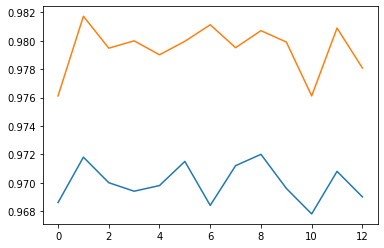

In [112]:
plt.plot(history_score)
plt.plot(history_score_train)

In [49]:
X_test_for_plt = MNIST_test.test_data
X_test_for_plt = X_test_for_plt.float()

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


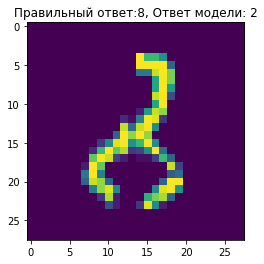

А на сегодня всёёёё


In [114]:

import time
from IPython.display import display, clear_output

"""

Прекрасное только то, что мы видим издалека. Не приближайтесь к прекрасному...
                                                  Александр Валентинович Вампилов. Из записных книжек

"""

for i in range(0, len(wrong_y_indexes)):
  try:
    n = wrong_y_indexes[i]
    ax = plt.imshow(X_test_for_plt[n, :, :])
    plt.title("Правильный ответ:"+str(y_test.cpu().numpy()[n])+ ", Ответ модели: "+ str(int(wrong_predict[i])))
    clear_output(wait=True)
    display()
    plt.show(block = False)
    time.sleep(2)
  except KeyboardInterrupt:
    print("А на сегодня всёёёё")
    break